In [1]:
import pandas as pd

In [2]:
df_customers = pd.read_csv('olist_customers_dataset.csv')
df_geolocation = pd.read_csv('olist_geolocation_dataset.csv')
df_order_items = pd.read_csv('olist_order_items_dataset.csv')
df_order_payments = pd.read_csv('olist_order_payments_dataset.csv')
df_order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
df_orders = pd.read_csv('olist_orders_dataset.csv')
df_products = pd.read_csv('olist_products_dataset.csv')
df_sellers = pd.read_csv('olist_sellers_dataset.csv')
df_product_category_name = pd.read_csv('product_category_name_translation.csv')

df_train = df_orders.merge(df_order_items, on='order_id', how='left')
df_train = df_train.merge(df_order_payments, on='order_id', how='outer', validate='m:m')
df_train = df_train.merge(df_order_reviews, on='order_id', how='outer')
df_train = df_train.merge(df_products, on='product_id', how='outer')
df_train = df_train.merge(df_customers, on='customer_id', how='outer')
df_train = df_train.merge(df_sellers, on='seller_id', how='outer')
df_train = df_train.merge(df_product_category_name, on='product_category_name', how='inner')

In [3]:
df_train.columns.tolist()

['order_id',
 'customer_id',
 'order_status',
 'order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'order_item_id',
 'product_id',
 'seller_id',
 'shipping_limit_date',
 'price',
 'freight_value',
 'payment_sequential',
 'payment_type',
 'payment_installments',
 'payment_value',
 'review_id',
 'review_score',
 'review_comment_title',
 'review_comment_message',
 'review_creation_date',
 'review_answer_timestamp',
 'product_category_name',
 'product_name_lenght',
 'product_description_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'customer_unique_id',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'seller_zip_code_prefix',
 'seller_city',
 'seller_state',
 'product_category_name_english']

Train R^2 Score: 0.8104731040197065
Test R^2 Score: 0.2624450665671618


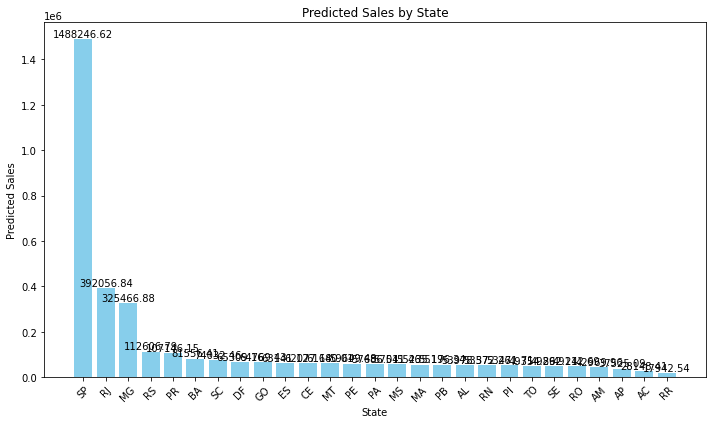

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Load the data

# Convert 'order_purchase_timestamp' to datetime
df_train['order_purchase_timestamp'] = pd.to_datetime(df_train['order_purchase_timestamp'])

# Calculate the last four months
last_four_months = df_train['order_purchase_timestamp'].max() - pd.DateOffset(months=4)

# Filter data for the last four months
df_train_last_four_months = df_train[df_train['order_purchase_timestamp'] >= last_four_months]

# Aggregate sales data by state and product category
sales_data = df_train_last_four_months.groupby(['customer_state', 'product_category_name_english']).agg({
    'price': 'sum',
}).reset_index()

# Add a time lag feature for previous month's sales
sales_data['previous_month_sales'] = sales_data.groupby(['customer_state', 'product_category_name_english'])['price'].shift(1)

# Fill missing values with 0
sales_data['previous_month_sales'].fillna(0, inplace=True)

# Prepare features and target variable
X = sales_data.drop(['price'], axis=1)  # Features: state, product category, previous month sales
y = sales_data['price']  # Target variable: total sales

# Convert categorical variables into dummy variables
X = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
train_score = r2_score(y_train, model.predict(X_train))
test_score = r2_score(y_test, model.predict(X_test))
print("Train R^2 Score:", train_score)
print("Test R^2 Score:", test_score)

# Predict sales for each state
predictions = model.predict(X)

# Create a dataframe with predicted sales
predicted_sales = pd.DataFrame({
    'customer_state': sales_data['customer_state'],
    'product_category_name_english': sales_data['product_category_name_english'],
    'predicted_sales': predictions
})

# Group by state and sum the predicted sales
predicted_sales_by_state = predicted_sales.groupby('customer_state')['predicted_sales'].sum().reset_index()

# Sort states by predicted sales
predicted_sales_by_state = predicted_sales_by_state.sort_values(by='predicted_sales', ascending=False)

# Visualize the results
plt.figure(figsize=(10, 6))
bars = plt.bar(predicted_sales_by_state['customer_state'], predicted_sales_by_state['predicted_sales'], color='skyblue')
plt.xlabel('State')
plt.ylabel('Predicted Sales')
plt.title('Predicted Sales by State')
plt.xticks(rotation=45)
plt.tight_layout()

# Add numbers on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

plt.show()


In [5]:
# Create a dataframe with predicted sales by state
predicted_sales_by_state = predicted_sales.groupby('customer_state')['predicted_sales'].sum().reset_index()

# Sort states by predicted sales in descending order
predicted_sales_by_state = predicted_sales_by_state.sort_values(by='predicted_sales', ascending=False)

# Format predicted sales as money
predicted_sales_by_state['predicted_sales'] = predicted_sales_by_state['predicted_sales'].map('${:,.2f}'.format)

# Display the dataframe
predicted_sales_by_state

,customer_state,predicted_sales
25,SP,"$1,488,246.62"
18,RJ,"$392,056.84"
10,MG,"$325,466.88"
22,RS,"$112,606.79"
17,PR,"$107,146.15"
4,BA,"$81,556.41"
23,SC,"$74,032.46"
6,DF,"$65,309.16"
8,GO,"$64,769.43"
7,ES,"$63,141.12"


In [6]:
# Define a function to format the predicted sales as money values
def format_money(value):
    return "${:,.2f}".format(value)

# Group by state and product category, sum the predicted sales
grouped_sales = predicted_sales.groupby(['customer_state', 'product_category_name_english'])['predicted_sales'].sum().reset_index()

# Get top 3 products for each state
top3_products = grouped_sales.groupby('customer_state').apply(lambda x: x.nlargest(3, 'predicted_sales')).reset_index(drop=True)

# Format predicted sales as money values
top3_products['predicted_sales'] = top3_products['predicted_sales'].map(format_money)

top3_products


,customer_state,product_category_name_english,predicted_sales
0,AC,health_beauty,"$8,655.59"
1,AC,watches_gifts,"$8,182.79"
2,AC,sports_leisure,"$4,351.06"
3,AL,health_beauty,"$8,915.51"
4,AL,watches_gifts,"$8,442.71"
...,...,...,...
76,SP,bed_bath_table,"$114,378.56"
77,SP,watches_gifts,"$99,051.94"
78,TO,health_beauty,"$8,915.51"
79,TO,watches_gifts,"$8,442.71"
